In [ ]:
# 1. Importy
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt  

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# 2. Wczytanie danych (tylko to, czego używamy)
DATA_PATH = "data"
df_days = pd.read_csv(os.path.join(DATA_PATH, "ph_v1_days.csv"))

# 3. Wstępne przetwarzanie
def clean_columns(df):
    df.columns = [c.strip().replace(" ", "_").lower() for c in df.columns]
    return df

df_days = clean_columns(df_days)
df_days["date"] = pd.to_datetime(df_days["date"], errors="coerce", dayfirst=True)

# proste uzupełnienie braków
df_days = df_days.fillna(0)

# skalowanie liquid (może być przydatne jako cecha)
scaler = StandardScaler()
df_days["liquid_scaled"] = scaler.fit_transform(df_days[["liquid"]])

# średnie pH + klasa binarna
df_days["ph_avg"] = (
    df_days[["ph_morning", "ph_midday", "ph_evening"]]
    .replace(0, np.nan)
    .mean(axis=1)
    .fillna(df_days["ph_avg"])
)

df_days["ph_class"] = np.where(
    (df_days["ph_avg"] >= 6.4) & (df_days["ph_avg"] <= 6.8),
    1,
    0
)

# 4. Klasyfikacja – przygotowanie X, y
X = df_days.drop(
    columns=["date", "ph_morning", "ph_midday", "ph_evening", "ph_avg", "ph_class"]
)
y = df_days["ph_class"]

num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

num_tf = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler())
])

cat_tf = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

pre = ColumnTransformer([
    ("num", num_tf, num_features),
    ("cat", cat_tf, cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

clf = Pipeline([
    ("prep", pre),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

clf.fit(X_train, y_train)

# 5. Podstawowe metryki (spójne z notatnikiem z interpretowalności)
proba = clf.predict_proba(X_test)[:, 1]
pred = (proba >= 0.5).astype(int)

print("ACC:", accuracy_score(y_test, pred))
print("ROC AUC:", roc_auc_score(y_test, proba))


ACC: 0.7674418604651163
ROC AUC: 0.6107142857142857


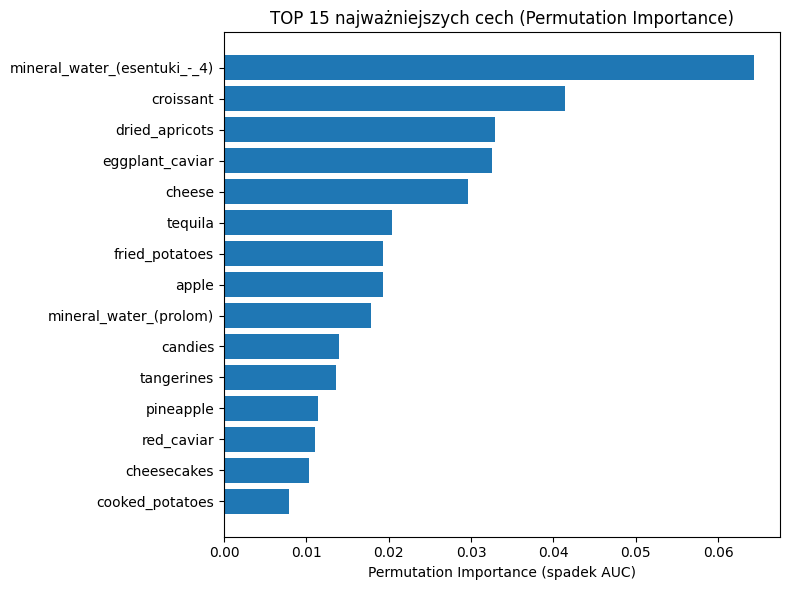

,feature,PI_mean,PI_std
8,mineral_water_(esentuki_-_4),0.064286,0.026726
87,croissant,0.041429,0.035686
66,dried_apricots,0.032857,0.025991
68,eggplant_caviar,0.032500,0.013965
33,cheese,0.029643,0.035140
11,tequila,0.020357,0.017861
51,fried_potatoes,0.019286,0.017656
70,apple,0.019286,0.018225
10,mineral_water_(prolom),0.017857,0.013740
89,candies,0.013929,0.025327


In [ ]:

from sklearn.inspection import permutation_importance

# Użyjemy AUC jako miary jakości (spójnie z tym, co liczyłeś wyżej)
pi = permutation_importance(
    clf,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="roc_auc"
)

imp = pd.DataFrame({
    "feature": X_test.columns,
    "PI_mean": pi.importances_mean,
    "PI_std": pi.importances_std
})


top_n = 15

# sortowanie malejąco
imp_sorted = imp.sort_values("PI_mean", ascending=False)

# wybranie TOP 15
imp_top = imp_sorted.head(top_n)

# wykres
plt.figure(figsize=(8,6))
plt.barh(imp_top["feature"], imp_top["PI_mean"])
plt.xlabel("Permutation Importance (spadek AUC)")
plt.title(f"TOP {top_n} najważniejszych cech (Permutation Importance)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# wyświetlenie tabeli TOP 15
imp_top


Cechy do PDP/ICE: ['mineral_water_(esentuki_-_4)', 'croissant', 'dried_apricots']


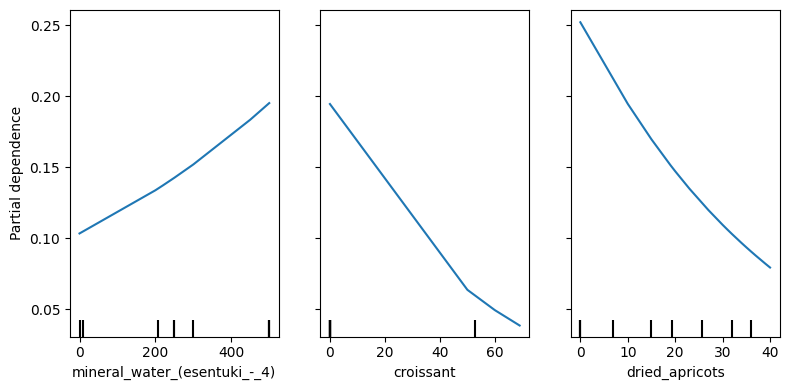

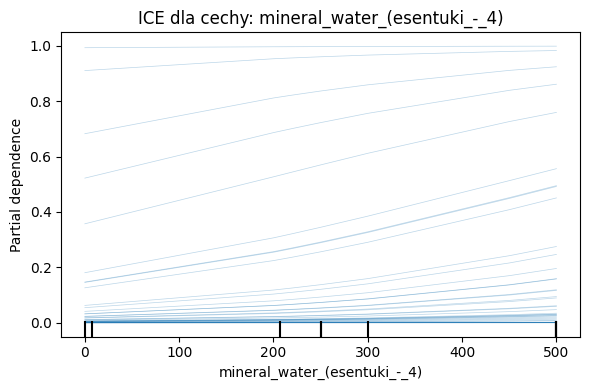

In [ ]:


top_n_pdp = 3  # np. 3 najważniejsze cechy

# poprawione sortowanie
imp_sorted = imp.sort_values("PI_mean", ascending=False)

top_features = imp_sorted.head(top_n_pdp)["feature"].tolist()

print("Cechy do PDP/ICE:", top_features)

# --- PDP: zależności globalne dla TOP 3 cech ---
fig, ax = plt.subplots(figsize=(8, 4))
PartialDependenceDisplay.from_estimator(
    clf,
    X_test,
    features=top_features,
    kind="average",
    ax=ax
)
plt.tight_layout()
plt.show()

# --- ICE: zależności lokalne dla najważniejszej cechy ---
main_feature = top_features[0]

fig, ax = plt.subplots(figsize=(6, 4))
PartialDependenceDisplay.from_estimator(
    clf,
    X_test,
    features=[main_feature],
    kind="individual",
    subsample=100,
    ax=ax
)
plt.title(f"ICE dla cechy: {main_feature}")
plt.tight_layout()
plt.show()


Using 169 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/43 [00:00<?, ?it/s]

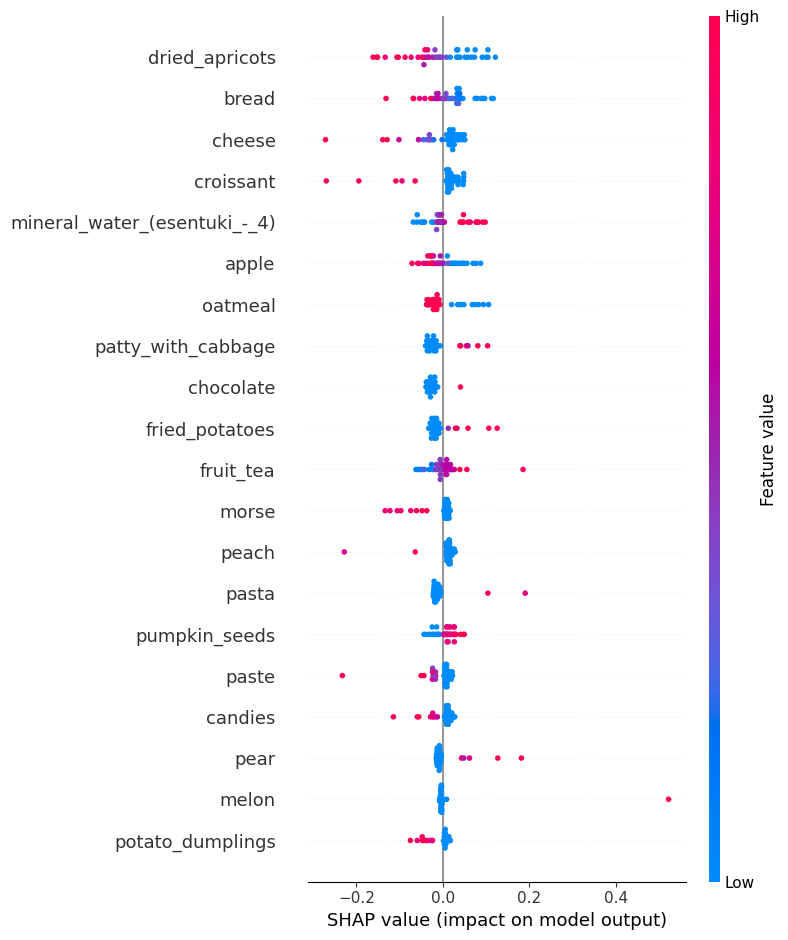

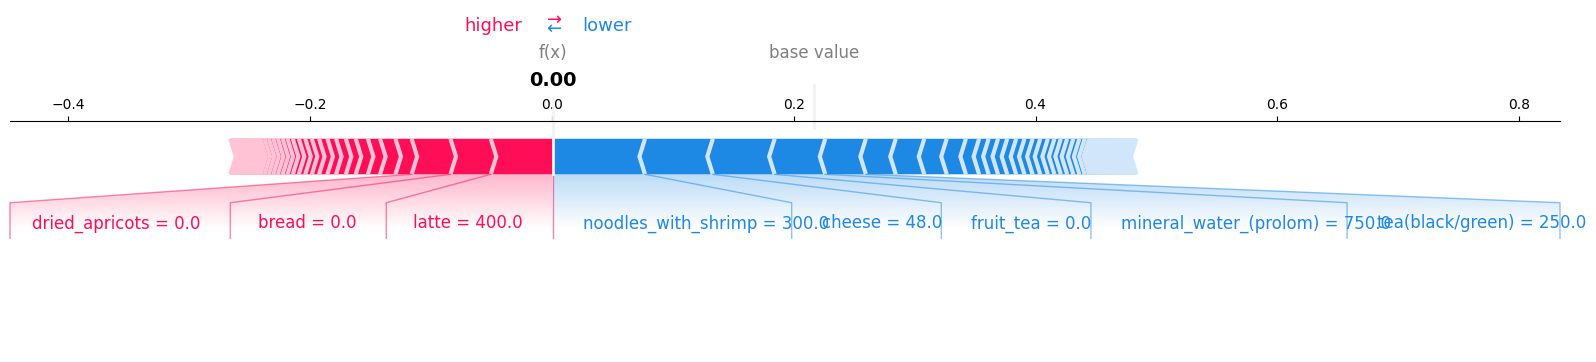

In [ ]:
import shap


X_train_df = X_train.copy()
cols = X_train_df.columns.tolist()

def model_predict(X_in):

    if isinstance(X_in, np.ndarray):
        X_df = pd.DataFrame(X_in, columns=cols)
    else:
        X_df = X_in  
    return clf.predict_proba(X_df)[:, 1]

background = X_train_df.sample(
    n=min(200, len(X_train_df)),
    random_state=42
)

explainer = shap.KernelExplainer(
    model_predict,
    background
)

X_sample = X_test.sample(
    n=min(200, len(X_test)),
    random_state=42
)

shap_values = explainer.shap_values(X_sample)

shap.summary_plot(
    shap_values,
    X_sample,
    feature_names=X_sample.columns,
    show=True
)


i = 0  
shap.force_plot(
    explainer.expected_value,
    shap_values[i, :],
    X_sample.iloc[i, :],
    matplotlib=True
)
plt.show()


In [12]:
try:
    from lime.lime_tabular import LimeTabularExplainer

    # 1. Dane dla LIME: wszystkie cechy z X (num + kat)
    feature_names = X_train.columns.tolist()
    X_train_np = X_train.to_numpy()
    X_test_np  = X_test.to_numpy()

    print("Cechy używane przez LIME:", feature_names)

    explainer = LimeTabularExplainer(
        training_data=X_train_np,
        feature_names=feature_names,
        class_names=["pH_nie_ok", "pH_ok"],  # klasa 0, klasa 1
        discretize_continuous=True,
        mode="classification"
    )

    # 2. Funkcja predykcji: NUMPY -> DataFrame -> pipeline clf
    def predict_fn(x_np):
        X_df = pd.DataFrame(x_np, columns=feature_names)
        return clf.predict_proba(X_df)

    # 3. Wybieramy obserwację do wyjaśnienia
    i = 0  # np. pierwszy z testowych
    x0 = X_test_np[i]

    exp = explainer.explain_instance(
        data_row=x0,
        predict_fn=predict_fn,
        num_features=6,   # ile cech pokazać w wyjaśnieniu
        top_labels=1      # wyjaśniamy topową klasę
    )

    # bierzemy faktyczną "top label" zamiast zakładać, że to 1
    label = exp.top_labels[0]
    print("Wyjaśnienie LIME dla obserwacji", i, "| label =", label)

    for feat, val in exp.as_list(label=label):
        print(feat, "=>", val)

except Exception as e:
    print("LIME niedostępny lub błąd:", e)


Cechy używane przez LIME: ['ailment', 'gym', 'liquid', 'lemon_water', 'tea(black/green)', 'fruit_tea', 'water', 'latte', 'mineral_water_(esentuki_-_4)', 'mineral_water_(borjomi)', 'mineral_water_(prolom)', 'tequila', 'red_wine', 'white_wine', 'strong_alcohol', 'beer', 'morse', 'milk', 'orange_juice', 'oatmeal', 'pizza_with_meat', 'cheese_pizza', 'cheesecakes', 'scrambled_eggs', 'mayonnaise_salad', 'bread', 'meat', 'sauce', 'cutlet', 'sausage', 'fish', 'sushi', 'cod_liver', 'cheese', 'curd', 'sour_cream', 'buckwheat_porridge', 'noodles_with_vegetables', 'noodles_with_shrimp', 'meat_pilaf', 'meatless_pilaf', 'pea_soup_with_meat', 'fried_vegetables', 'pyagse_with_vegetables', 'dumplings_with_cabbage', 'potato_dumplings', 'zucchini_fritters', 'stewed_cabbage', 'solyanka_with_meat', 'eggplant_with_cheese', 'pasta', 'fried_potatoes', 'cooked_potatoes', 'braised_potatoes', 'mashed_potatoes', 'apple_pie', 'patty_with_cabbage', 'curd_pie', 'cheese_pie', 'egg_pie', 'potato_pie', 'meat_pie', 'kha

In [13]:
try:
    from lime.lime_tabular import LimeTabularExplainer

    # 1. NUMERYCZNE cechy do LIME (wszystko oprócz 'ailment')
    num_cols = X_train.drop(columns=["ailment"]).select_dtypes(include=["number"]).columns.tolist()
    X_train_num = X_train[num_cols].to_numpy()
    X_test_num  = X_test[num_cols].to_numpy()

    print("Cechy numeryczne używane przez LIME:", num_cols)

    explainer = LimeTabularExplainer(
        training_data=X_train_num,
        feature_names=num_cols,
        class_names=["pH_nie_ok", "pH_ok"],
        discretize_continuous=True,
        mode="classification"
    )

    # 2. Funkcja predykcji: NUMPY -> DataFrame + stała wartość 'ailment'
    def make_predict_fn_for_patient(ailment_value):
        """Zwraca funkcję predict_fn, która dokleja stałą wartość 'ailment'."""
        def predict_fn(x_num):
            X_df = pd.DataFrame(x_num, columns=num_cols)
            X_df["ailment"] = ailment_value
            return clf.predict_proba(X_df)
        return predict_fn

    # 3. Wybieramy obserwację do wyjaśnienia
    i = 0  # np. pierwszy z testowych
    x0_num    = X_test_num[i]
    ailment0  = X_test.iloc[i]["ailment"]

    predict_fn = make_predict_fn_for_patient(ailment0)

    exp = explainer.explain_instance(
        data_row=x0_num,
        predict_fn=predict_fn,
        num_features=6,
        top_labels=1
    )

    label = exp.top_labels[0]
    print("Wyjaśnienie LIME dla obserwacji", i, "| ailment =", ailment0, "| label =", label)
    for feat, val in exp.as_list(label=label):
        print(feat, "=>", val)

except Exception as e:
    print("LIME niedostępny lub błąd:", e)


Cechy numeryczne używane przez LIME: ['gym', 'liquid', 'lemon_water', 'tea(black/green)', 'fruit_tea', 'water', 'latte', 'mineral_water_(esentuki_-_4)', 'mineral_water_(borjomi)', 'mineral_water_(prolom)', 'tequila', 'red_wine', 'white_wine', 'strong_alcohol', 'beer', 'morse', 'milk', 'orange_juice', 'oatmeal', 'pizza_with_meat', 'cheese_pizza', 'cheesecakes', 'scrambled_eggs', 'mayonnaise_salad', 'bread', 'meat', 'sauce', 'cutlet', 'sausage', 'fish', 'sushi', 'cod_liver', 'cheese', 'curd', 'sour_cream', 'buckwheat_porridge', 'noodles_with_vegetables', 'noodles_with_shrimp', 'meat_pilaf', 'meatless_pilaf', 'pea_soup_with_meat', 'fried_vegetables', 'pyagse_with_vegetables', 'dumplings_with_cabbage', 'potato_dumplings', 'zucchini_fritters', 'stewed_cabbage', 'solyanka_with_meat', 'eggplant_with_cheese', 'pasta', 'fried_potatoes', 'cooked_potatoes', 'braised_potatoes', 'mashed_potatoes', 'apple_pie', 'patty_with_cabbage', 'curd_pie', 'cheese_pie', 'egg_pie', 'potato_pie', 'meat_pie', 'kha